### NCX Simulation Model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import random as random
import pandas as pd

---------------

### Parameters

In [4]:
K_EN1_ENO = 0.33
K_ENO_EN1 = 0.33
K_ENO_EN2 = 0.33
K_EN2_ENO = 0.33

K_EC1_ECO = 0.33
K_ECO_EC1 = 0.33
K_ECO_EC2 = 0.33
K_EC2_ECO = 0.33

#### Weighted Probability Vector

In [5]:
M = {"EN1": [1 - K_EN1_ENO,K_EN1_ENO,0,0,0,0],
    "ENO":  [K_ENO_EN1, 1-K_ENO_EN1-K_ENO_EN2,K_ENO_EN2,0,0,0],
    "EN2":  [0, K_EN2_ENO, 1-K_EN2_ENO,0,0,0],
     
     
    "EC1":  [0,0,0,1-K_EC1_ECO,K_EC1_ECO,0],
    "ECO":  [0,0,0,K_ECO_EC1,1-K_ECO_EC1-K_ECO_EC2,K_ECO_EC2],
    "EC2":  [0,0,0,0,K_EC2_ECO,1-K_EC2_ECO]}

In [6]:
M

{'EN1': [0.6699999999999999, 0.33, 0, 0, 0, 0],
 'ENO': [0.33, 0.3399999999999999, 0.33, 0, 0, 0],
 'EN2': [0, 0.33, 0.6699999999999999, 0, 0, 0],
 'EC1': [0, 0, 0, 0.6699999999999999, 0.33, 0],
 'ECO': [0, 0, 0, 0.33, 0.3399999999999999, 0.33],
 'EC2': [0, 0, 0, 0, 0.33, 0.6699999999999999]}

In [7]:
class Channel(object):
    '''This class represents a ncx channel'''
    def __init__(self,state,x,y):
        self.x = x
        self.y = y
        self.states = ["EN1","ENO","EN2","EC1","ECO", "EC2"]
        self.state = state
        
    def update(self,M):
        '''Update the state based on markov model'''
        new_state = np.random.choice(self.states, p = M[self.state])
        self.state = new_state
        
    def flip(self):
        if self.state in ["EN1","EC1"]:
            self.state = random.choice(["EN1","EC1"])
        elif self.state in ["EN2","EC2"]:
            self.state = random.choice(["EN2","EC2"])
        
           

----------------------

In [8]:
class System(object):
    '''This class represents a 2D lattice system of NCX channels'''
    def __init__(self,Channel,M):
        
        '''lattice dimension'''
        self.Lx = 20
        self.Ly = 20
        
        '''Markov transition matrix'''
        self.M = M
        
        '''A single channel object'''
        self.Channel = Channel
        
        '''concentration of ions'''
        self.nNa_out = 1000
        self.nCa_out = 1000
        self.nNa_in = 1000
        self.nCa_in = 1000
        self.nNa_o = 0
        self.nCa_o = 0
        
        '''concentration of channels'''
        self.nEN1 = 0
        self.nENO = 0
        self.nEN2 = 0
        self.nEC1 = 0
        self.nECO = 0
        self.nEC2 = 0
        
        '''Initiation channel 2D system'''
        self.U = [["o" for i in range(self.Lx)]for j in range(self.Ly)]
        
        self.DATA =[]
        
    def start(self):
        for i in range(self.Lx):
            for j in range(self.Ly):
                
                r_state = random.choice(["EC1","EN1"])
                self.U[i][j] = self.Channel(r_state,i,j)
                
                if r_state == "EN1":
                    self.nEN1 += 1
                if r_state == "ENO":
                    self.nENO += 1
                    self.nNa_o +=3
                if r_state == "EN2":
                    self.nEN2 += 1
                    
                if r_state == "EC1":
                    self.nEC1 += 1
                if r_state == "ECO":
                    self.nECO += 1
                    self.nCa_o += 1
                if r_state == "EC2":
                    self.nEC2 += 1
                
                
                
                
        
    def run(self, verbose = False):
        for i in range(self.Lx):
            for j in range(self.Ly):
                new_state = None 
                old_state = None 
                channel = self.U[i][j]
                old_state = channel.state
                '''generate the next markov state'''
                channel.update(self.M)
                new_state = channel.state
                
                if new_state != old_state:
                    
                    if verbose:
                        print("updated from", old_state, " to ", new_state,\
                          " at ", channel.x, channel.y)
                    
                    
                    '''update the ion concentration'''
                    if new_state == "EN1" and old_state == "ENO":
                            self.nNa_in += 1
                            self.nNa_o -= 1
                            self.nEN1 += 1
                            self.nENO -= 1
                    
                    elif new_state == "ENO" and old_state == "EN1":
                            self.nENO += 1
                            self.nEN1 -= 1
                            self.nNa_o += 1
                            self.nNa_in -= 1
                            
                    elif new_state == "ENO" and old_state =="EN2":
                            self.nENO += 1
                            self.nEN2 -= 1
                            self.nNa_o += 1
                            self.nNa_out -= 1
                        
                    
                    elif new_state == "EN2" and old_state == "ENO":
                            self.nNa_out += 1
                            self.nNa_o -= 1
                            self.nEN2 += 1
                            self.nENO -= 1
                            
                            
                    
                    elif new_state == "EC1" and old_state == "ECO":
                            self.nCa_in += 1
                            self.nCa_o -= 1
                            self.nEC1 += 1
                            self.nECO -= 1
                    
                    elif new_state == "ECO" and old_state == "EC1":
                            self.nECO += 1
                            self.nEC1 -= 1
                            self.nCa_o += 1
                            self.nCa_in -= 1
                            
                    elif new_state == "ECO" and old_state =="EC2":
                            self.nECO += 1
                            self.nEC2 -= 1
                            self.nCa_o += 1
                            self.nCa_out -= 1
                        
                    
                    elif new_state == "EC2" and old_state == "ECO":
                            self.nCa_out += 1
                            self.nCa_o -= 1
                            self.nEC2 += 1
                            self.nECO -= 1
                            
                else:
                    if verbose:
                        print("not updated"," old is ", old_state,\
                          " new is ",new_state,\
                          "at", channel.x, channel.y)
                    
                if channel.state in ["EN1","EN2","EC1","EC2"]:    
                    channel.flip()
                    fliped_state = channel.state
                    if verbose:
                        print("Flipped from ", new_state, " to ", fliped_state)
                
                    if new_state == "EN1":
                        if fliped_state == "EC1":
                            self.nEN1 -= 1
                            self.nEC1 += 1
                    elif new_state == "EN2":
                        if fliped_state == "EC2":
                            self.nEN2 -= 1
                            self.nEC2 += 1
                        
                    elif new_state == "EC1":
                        if fliped_state == "EN1":
                            self.nEC1 -= 1
                            self.nEN1 += 1
                    elif new_state == "EC2":
                        if fliped_state == "EN2":
                            self.nEC2 -= 1
                            self.nEN2 += 1
                        
                
                        
                self.U[i][j] = channel
                
                
                
                
                
    def simulate(self,T):
        self.DATA =[]
        for t in range(T):
            self.run()
            self.DATA.append({"time" : t,\
                              "EN1": self.nEN1,\
                              "ENO": self.nENO,\
                              "EN2": self.nEN2,\
                              "EC1": self.nEC1,\
                              "EC2": self.nEC2,\
                              "ECO": self.nECO,\
                              "Na_out": self.nNa_out,\
                              "Na_in": self.nNa_in,\
                              "Na_occ": self.nNa_o,\
                              "CA_occ": self.nCa_o,\
                              "Ca_in": self.nCa_in,\
                              "Ca_out": self.nCa_out})
                

### Simulation

In [9]:
S = System(Channel,M)
S.start()
S.simulate(T=100)

### DataFrame

In [10]:
DF = pd.DataFrame(S.DATA)
DF.head(5)

,CA_occ,Ca_in,Ca_out,EC1,EC2,ECO,EN1,EN2,ENO,Na_in,Na_occ,Na_out,time
0,76,924,1000,120,0,76,140,0,64,936,64,1000,0
1,66,909,1025,130,25,66,96,21,62,917,62,1021,1
2,76,880,1044,86,42,76,106,35,55,912,55,1033,2
3,60,880,1060,90,40,60,91,62,57,901,57,1042,3
4,48,884,1068,93,51,48,84,58,66,893,66,1041,4


### Results

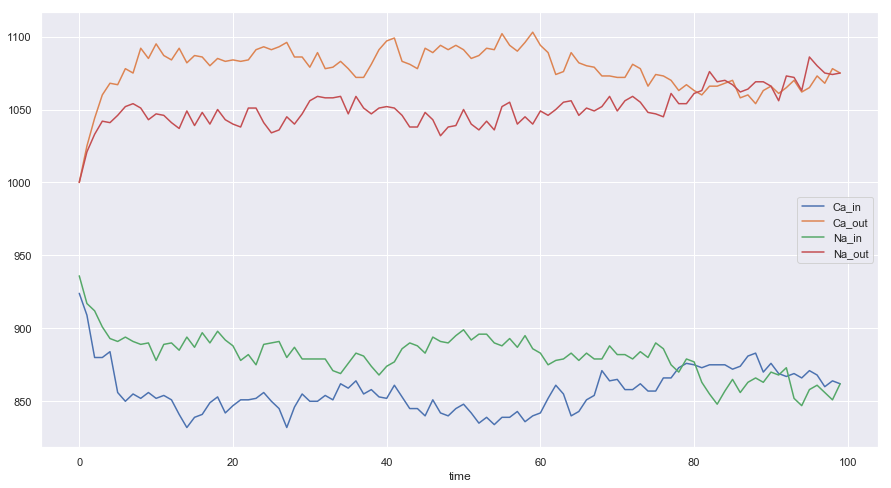

In [15]:
DF.plot(x = "time", y =["Ca_in","Ca_out","Na_in","Na_out"],figsize = [15,8])

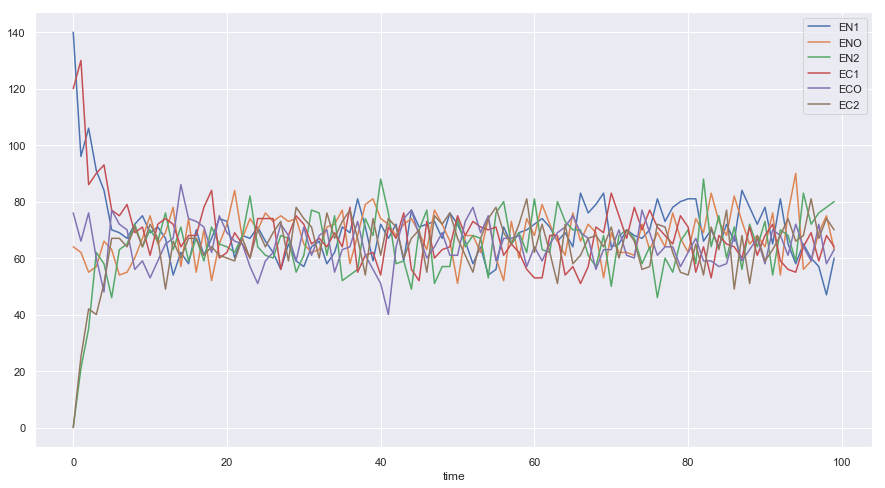

In [16]:
DF.plot(x = "time", y =["EN1","ENO","EN2","EC1","ECO","EC2"],figsize = [15,8])

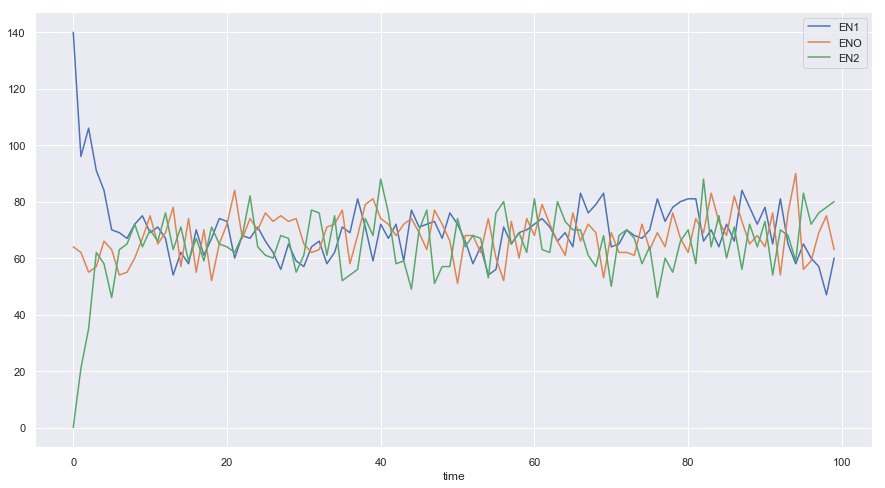

In [17]:
DF.plot(x = "time", y =["EN1","ENO","EN2"],figsize = [15,8])

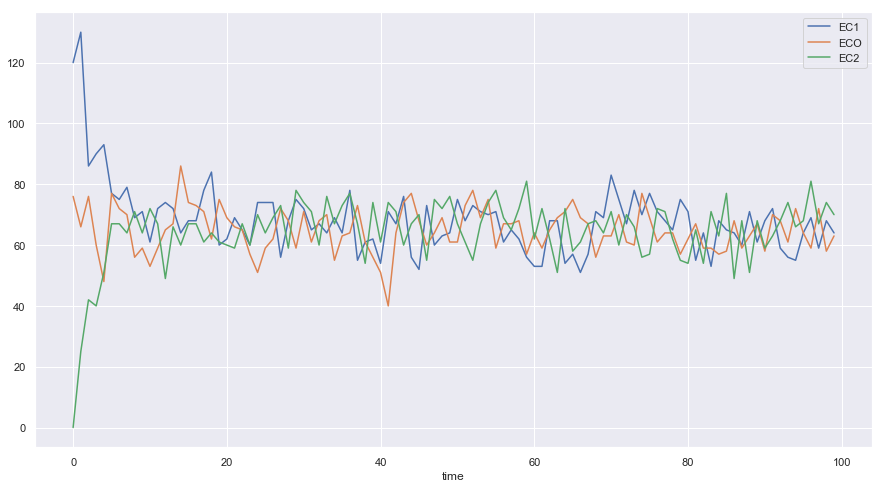

In [18]:
DF.plot(x = "time", y =["EC1","ECO","EC2"],figsize = [15,8])

#### Markov Chain

In [179]:
C = Channel("EN1",2,2)
print(C.state)
for i in range(10):
    C.update(M)
    print(C.state)
    C.flip()
    print(C.state)

EN1
ENO
ENO
ENO
ENO
ENO
ENO
EN1
EC1
EC1
EN1
ENO
ENO
EN2
EC2
ECO
ECO
EC2
EN2
EN2
EC2
